# APS360 Final Project: Covid Mask Detector

### Names: Edwin Zhang, Lance Canlas, Stefano Katsoras, Marie Joy Cuevas

This file contains everything related to training our neural network(s).

## Global Imports

In [1]:
#Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os
import random


In [2]:
#Seed constant
SEED_CONST = 2020
#Set seeds to ensure repeatable training
def seed_torch(seed=SEED_CONST):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print("Set all seeds to {}".format(seed))

#initializes worker function for dataloaders
def _init_fn(worker_id):
    np.random.seed(SEED_CONST + worker_id)

## Loading Our Data

Split the data set into 60% train, 20% valdation, 20% test. Image pre-processing code is in image-preprocessing.ipynb file


In [3]:
#Master dataset
master = torchvision.datasets.ImageFolder('data_color_shifted', transform = transforms.ToTensor())

#split indexes
train_size = int(0.6 * len(master))
val_size = int(0.2 *len(master))
test_size = len(master) - val_size - train_size

train_set, val_set, test_set = torch.utils.data.random_split(master, [train_size, val_size, test_size])
print ("Length of training set: {}".format(len(train_set)))
print ("Length of val set: {}".format(len(val_set)))
print ("Length of test set: {}".format(len(test_set)))

Length of training set: 3485
Length of val set: 1161
Length of test set: 1163


In [4]:
def display_data (data_loader):
    '''
    Displays a few images to see if our data loaded properly
    
    data_loader: torch data_loader
    data_type: a string to show which data is displayed
    '''

    classes = ['Incorrect Mask', 'Mask', 'No Mask'] #CHANGED

    data = iter(data_loader)
    image, label = data.next()
    npImages = image.numpy() 
    
    # plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(npImages[i], (1, 2, 0)))
        ax.set_title(classes[label[i]])

#### Check Our Training Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


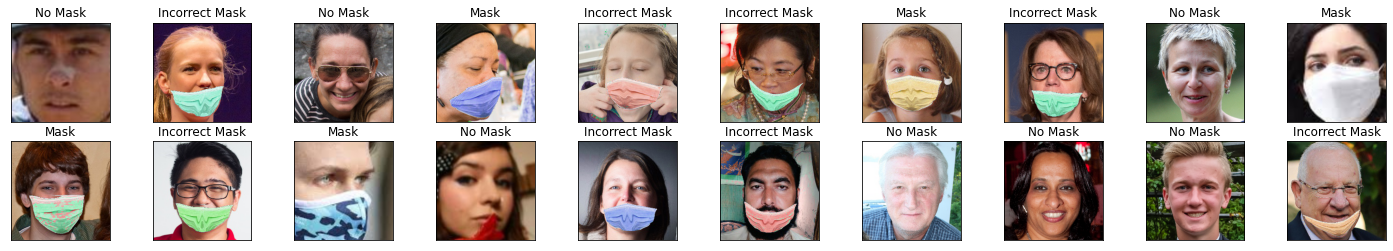

In [5]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1, shuffle=True)
display_data(train_data)

#### Check Our Validation Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


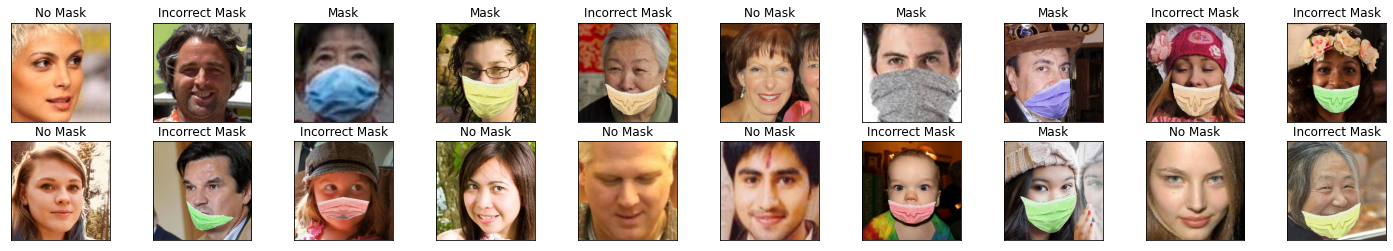

In [6]:
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1, shuffle=True)
display_data(val_data)

#### Check Our Test Data

<ipython-input-4-5946c92dc02c>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


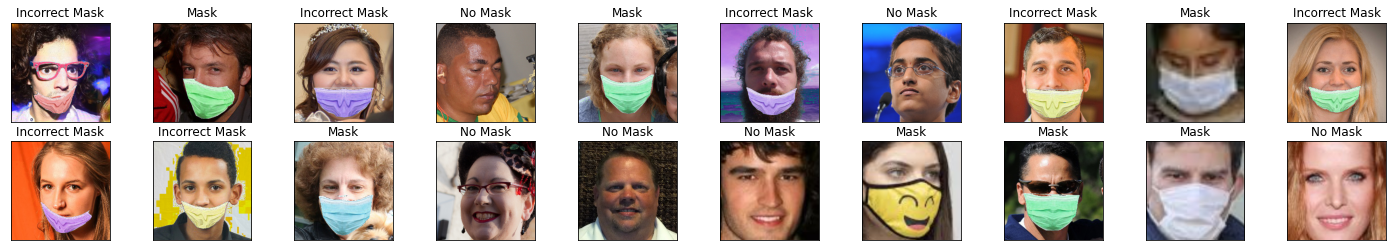

In [7]:
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1, shuffle=True)
display_data(test_data)

## Neural Networks
All of our networks are Convolutional Neural Networks due to their advantages while working with image classification problems.
All CNNs receive at RGB 240x240 input has a final output layer of 3 neurons for mask, no mask and incorrect mask.

Note: CNN versions do not indicate their success. For example version 2 may not necessarily be better than version 1

## Basic CNN Model - Version 1
This is the basic CNN version model, that has similar parameters to the CNN known as LeNet-5 (with 2 convolutional and pooling layers, followed by a flattening convolutional layer, then two linear layers). The SGD optimizer was used for our primary model because it is commonly used in CNNs and updates parameters based on each training sample.

In [8]:
class Basic_CNN(nn.Module):
    # 7 layers: 2 conv, 2 max pool, 2 linear, 1 output
    def __init__(self):
        self.name = "Basic_CNN"
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
        self.fc1 = nn.Linear(10*57*57, 32)
        self.fc2 = nn.Linear(32, 3) #CHANGED
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight.data)
            nn.init.xavier_uniform(m.bias.data)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img))) #relu activation function
        x = self.pool(F.relu(self.conv2(x))) #relu activation function
        x = x.view(-1, 10*57*57)
        x = F.relu(self.fc1(x)) #relu activation function
        x = self.fc2(x)
        return x

## Training Helper Functions

In [8]:
def get_accuracy(model, data_loader):
    '''
    Gets Correct/total
    
    Model: The CNN Model
    
    data_loader: torch dataloader
    '''
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [9]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    #Load data
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print("Done loading data")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    print ("Starting to train...")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        print("Epoch #: {0} Accuracy: {1}".format(epoch, train_acc[epoch]))
        
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    
    best_epoch = np.argmax(val_acc)
    model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, best_epoch)
    torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Epoch: {} (Train Acc = {}, Val Acc = {})".format(best_epoch, train_acc[best_epoch], val_acc[best_epoch]))

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.5365853658536586
Epoch #: 1 Accuracy: 0.6823529411764706
Epoch #: 2 Accuracy: 0.7555236728837876
Epoch #: 3 Accuracy: 0.8083213773314204
Epoch #: 4 Accuracy: 0.8091822094691535
Epoch #: 5 Accuracy: 0.8378766140602583
Epoch #: 6 Accuracy: 0.8269727403156385
Epoch #: 7 Accuracy: 0.848780487804878
Epoch #: 8 Accuracy: 0.8642754662840746
Epoch #: 9 Accuracy: 0.8680057388809183


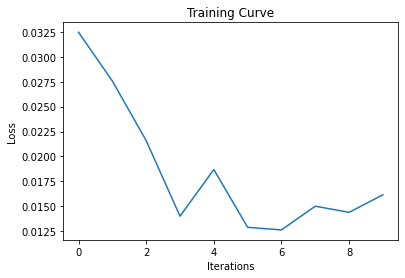

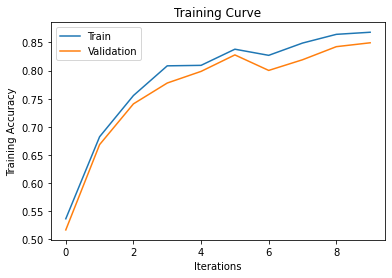

Final Training Accuracy: 0.8680057388809183
Final Validation Accuracy: 0.8492678725236865


In [12]:
use_cuda = True
torch.manual_seed(2020)
model = Basic_CNN()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 10)

In [13]:
#Test
best_model = Basic_CNN()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("Basic_CNN", 32, 0.00012, 8)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("test accuracy:", test_accuracy)

test accuracy: 0.8503869303525365


## CNN Model - Version 2
3 conv + pool layers

dropout layer

In [29]:
# Create a neural net class
class CNN_V2(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V2, self).__init__()
        self.name = "CNN_V2"
        
        # Our images are RGB, so we have input channels = 3. 
        #12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1)
        
        # A third convolutional layer takes 24 input channels, and generates 36 outputs
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, stride=1)
        
        # Max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240x3 ==conv1=> 236x236x12 ==pool=> 118x118x12 ==conv2=> 114x114x24 ==pool=> 57x57x24 ==conv3=> 54x54x36
        self.fc = nn.Linear(in_features=54 * 54 * 36, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  

        # Use a ReLU activation after layer 3 (no maxpooling)
        x = F.relu(self.conv3(x))

        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 54 * 54 * 36)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.4866571018651363
Epoch #: 1 Accuracy: 0.5779053084648493
Epoch #: 2 Accuracy: 0.7380200860832138
Epoch #: 3 Accuracy: 0.7566714490674319
Epoch #: 4 Accuracy: 0.8226685796269727
Epoch #: 5 Accuracy: 0.8418938307030129
Epoch #: 6 Accuracy: 0.8674318507890961
Epoch #: 7 Accuracy: 0.8711621233859398
Epoch #: 8 Accuracy: 0.8806312769010043
Epoch #: 9 Accuracy: 0.8803443328550933


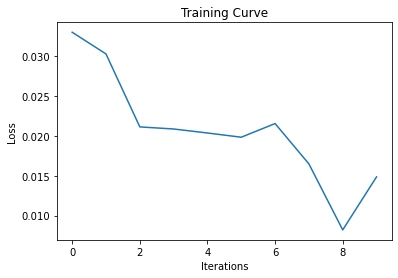

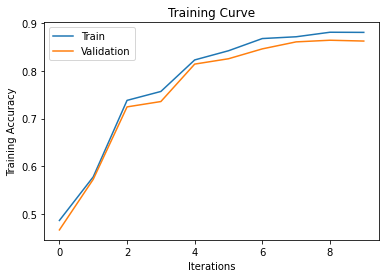

Final Training Accuracy: 0.8803443328550933
Final Validation Accuracy: 0.8621877691645133
Best Epoch: 8 (Train Acc = 0.8806312769010043, Val Acc = 0.8639104220499569)


In [30]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V2()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 10)

In [31]:
#Test
best_model = CNN_V2()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V2", 32, 0.00012, 8)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.8770421324161651


CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.4866571018651363
Epoch #: 1 Accuracy: 0.5776183644189383
Epoch #: 2 Accuracy: 0.7377331420373028
Epoch #: 3 Accuracy: 0.7566714490674319
Epoch #: 4 Accuracy: 0.8226685796269727
Epoch #: 5 Accuracy: 0.8418938307030129
Epoch #: 6 Accuracy: 0.8674318507890961
Epoch #: 7 Accuracy: 0.8711621233859398
Epoch #: 8 Accuracy: 0.8803443328550933
Epoch #: 9 Accuracy: 0.8803443328550933
Epoch #: 10 Accuracy: 0.88493543758967
Epoch #: 11 Accuracy: 0.8889526542324246
Epoch #: 12 Accuracy: 0.896700143472023
Epoch #: 13 Accuracy: 0.9030129124820659
Epoch #: 14 Accuracy: 0.8995695839311334
Epoch #: 15 Accuracy: 0.9127690100430416
Epoch #: 16 Accuracy: 0.9064562410329986
Epoch #: 17 Accuracy: 0.9182209469153515
Epoch #: 18 Accuracy: 0.9251076040172166
Epoch #: 19 Accuracy: 0.9259684361549498
Epoch #: 20 Accuracy: 0.9342898134863702
Epoch #: 21 Accuracy: 0.9314203730272597
Epoch #: 22 Accuracy: 0.93715925

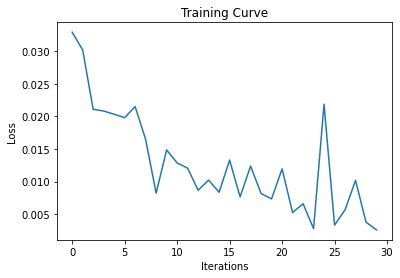

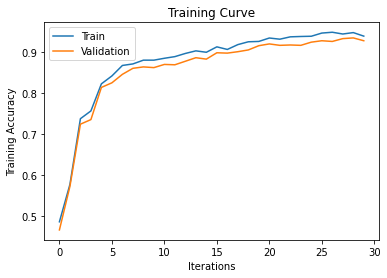

Final Training Accuracy: 0.9388809182209469
Final Validation Accuracy: 0.9276485788113695
Best Epoch: 28 (Train Acc = 0.9474892395982784, Val Acc = 0.9345391903531438)


In [34]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V2()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 30)

In [35]:
#Test
best_model = CNN_V2()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V2", 32, 0.00012, 28)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.9277730008598453


# CNN V3
1 conv layer with large kernel and stride

4 conv layers with no pooling

dropout layer

In [34]:
class CNN_V3(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_V3, self).__init__()
        self.name = "CNN_V3"
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=4, padding=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=6, stride=1)
        
        self.drop = nn.Dropout2d(p=0.2)
        
        # 240x240x3 ==conv1=> 60x60x64 ==4 conv layers=> 40x40x64
        self.fc = nn.Linear(in_features=40*40*64, out_features=num_classes)

    def forward(self, x):
        # Convolution with large kernel + stride to prevent need for max pooling (maintains accuracy and speeds up training)
        x = F.relu(self.conv1(x)) 
        
        # 64 feature convolutional layers
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv2(x))  

        # Dropout layer
        x = F.dropout(self.drop(x), training=self.training)
        
        x = x.view(-1, 40*40*64)
        x = self.fc(x)
        
        return torch.log_softmax(x, dim=1)

CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.3586800573888092
Epoch #: 1 Accuracy: 0.3581061692969871
Epoch #: 2 Accuracy: 0.40258249641319943
Epoch #: 3 Accuracy: 0.5523672883787661
Epoch #: 4 Accuracy: 0.7807747489239598
Epoch #: 5 Accuracy: 0.8416068866571018
Epoch #: 6 Accuracy: 0.8395982783357245
Epoch #: 7 Accuracy: 0.854232424677188
Epoch #: 8 Accuracy: 0.8639885222381636
Epoch #: 9 Accuracy: 0.8754662840746055
Epoch #: 10 Accuracy: 0.8757532281205165
Epoch #: 11 Accuracy: 0.8634146341463415
Epoch #: 12 Accuracy: 0.8714490674318508
Epoch #: 13 Accuracy: 0.9012912482065997
Epoch #: 14 Accuracy: 0.9081779053084649
Epoch #: 15 Accuracy: 0.9153515064562411
Epoch #: 16 Accuracy: 0.9253945480631277
Epoch #: 17 Accuracy: 0.9222381635581062
Epoch #: 18 Accuracy: 0.9305595408895265
Epoch #: 19 Accuracy: 0.9365853658536586
Epoch #: 20 Accuracy: 0.9472022955523672
Epoch #: 21 Accuracy: 0.9472022955523672
Epoch #: 22 Accuracy: 0.94232

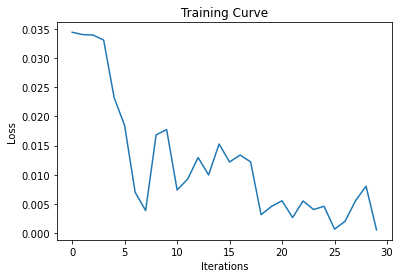

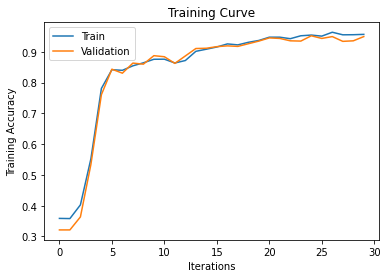

Final Training Accuracy: 0.9563845050215208
Final Validation Accuracy: 0.9491817398794143
Best Epoch: 24 (Train Acc = 0.9540889526542324, Val Acc = 0.9517657192075797)


In [13]:
use_cuda = True
torch.manual_seed(2020)
model = CNN_V3()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00015, num_epochs = 30)

In [39]:
#Test
best_model = CNN_V3()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN_V3", 32, 0.0002, 29)
state = torch.load(best_model_path)

best_model.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.9750644883920895
